<a href="https://colab.research.google.com/github/RezuanChowdhuryRifat/Bad-root-canal-detection/blob/main/Models/SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
using_colab = True
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-wndkdz1n
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-wndkdz1n
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=db8608a3a2c95ffdbd61c48d09fadda6a9092b3c9023902b5675bdad303663d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-mmz2ed5p/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segm

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
    
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)      

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/content/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [ ]:
import numpy as np

def read_bounding_boxes_from_txt(file_path, image: np.ndarray):
    bboxes = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            # Split the line into individual values
            values = line.strip().split()

            # Extract the bounding box coordinates
            x, y, width, height = map(float, values[1:5])

            # Convert normalized coordinates to absolute pixel coordinates
            x = x * image.shape[1]
            y = y * image.shape[0]
            width = width * image.shape[1]
            height = height * image.shape[0]

            # Convert to xmin, ymin, xmax, ymax format
            xmin = x - width / 2
            ymin = y - height / 2
            xmax = x + width / 2
            ymax = y + height / 2

            bboxes.append([xmin, ymin, xmax, ymax])

    return bboxes

In [ ]:
import cv2
import numpy as np

image_path = "/content/drive/MyDrive/flexible-yolov5/od/custom dataset/images/test/ptf (1)501.jpg"
annotation_path ="/content/drive/MyDrive/flexible-yolov5/od/custom dataset/labels/test/ptf (1)501.txt"
image = cv2.imread(image_path)
bbox = read_bounding_boxes_from_txt(annotation_path, image)
input_boxes = torch.tensor(bbox, device=predictor.device)

predictor.set_image(image)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)


In [ ]:
masks

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]],


        [[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]],


        [[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, Fa

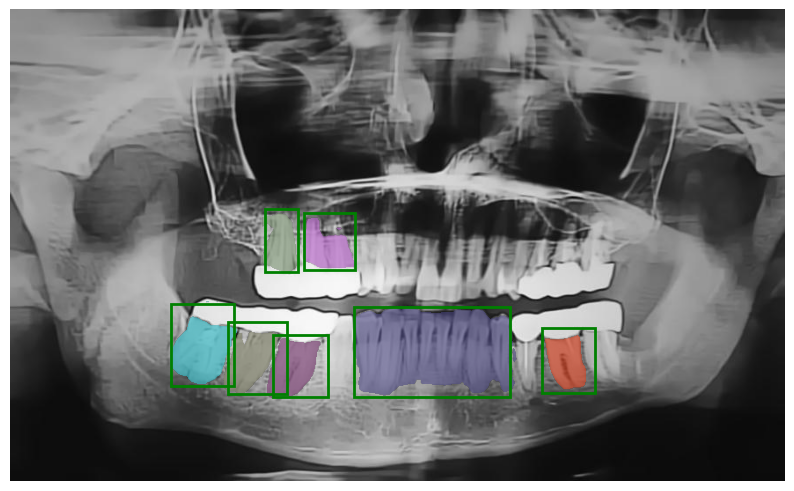

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

In [ ]:
masks.sum()

31281

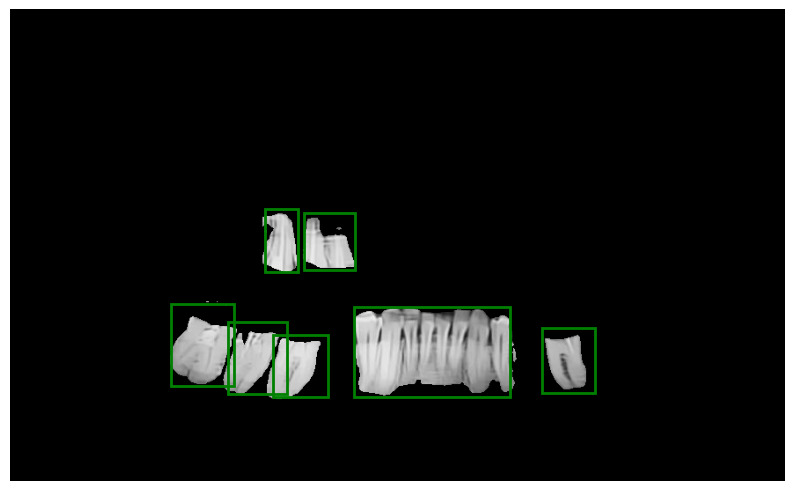

In [ ]:
import cv2

annotation_path ="/content/drive/MyDrive/flexible-yolov5/od/custom dataset/labels/test/ptf (1)501.txt"
image = cv2.imread("/content/sample_data/download (4).png")
bbox = read_bounding_boxes_from_txt(annotation_path, image)

plt.figure(figsize=(10, 10))
plt.imshow(image)
for box in bbox:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
from PIL import Image

def cutout_objects(image_path, mask_tensors):
    # Load the image
    image = Image.open(image_path)

    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Create an empty mask to store the cutout
    cutout_mask = np.zeros_like(image_array)

    # Iterate over each mask tensor
    for mask_tensor in masks:
        # Convert the mask tensor to a NumPy array
        mask_array = mask_tensor.cpu().numpy()

            # Resize the mask array to match the image dimensions
        mask_array = np.resize(mask_array, image_array.shape[:2])

        # Expand the dimensions of the mask array to match the image dimensions
        mask_array = np.expand_dims(mask_array, axis=2)
                # Remove the extra dimension from the mask array
        mask_array = np.squeeze(mask_array)


        # Multiply the image array by the mask array to cut out the object
        cutout_mask += image_array * mask_array

    # Convert the cutout mask array back to an image
    cutout_image = Image.fromarray(cutout_mask.astype(np.uint8))

    return cutout_image




In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.88,
    min_mask_region_area = 100
)

In [ ]:
image = cv2.imread('/content/images/ptf (1)501_0_0.jpg')

In [ ]:
masks = mask_generator.generate(image)

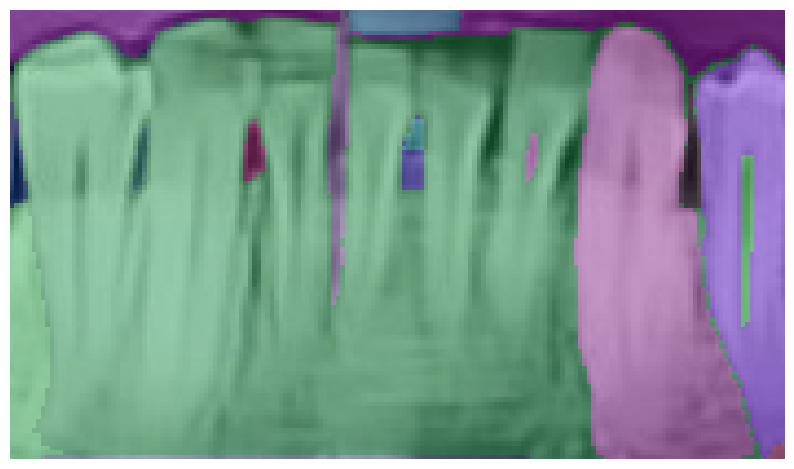

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [ ]:
image = cv2.imread('/content/images/ptf (101)505_3_1.jpg')

In [ ]:
masks = mask_generator.generate(image)

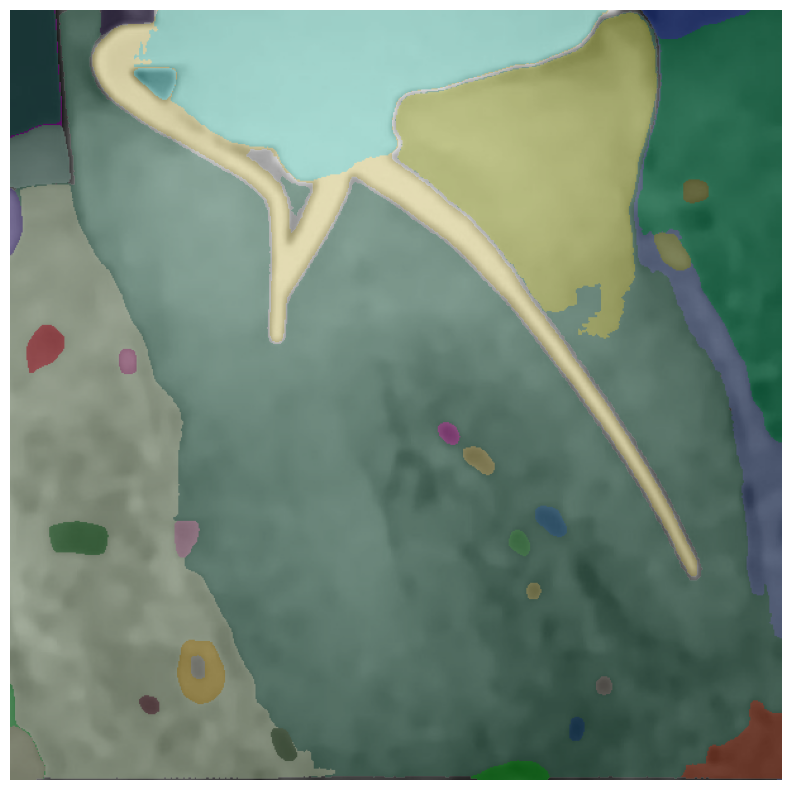

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [ ]:
!unzip "/content/drive/MyDrive/Radiographic Dataset/labels.zip" -d "/content/drive/MyDrive/Radiographic Dataset"

In [ ]:
import os
import cv2

def convert_folder_to_grayscale(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Get a list of all image files in the input folder
    image_files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

    # Iterate over each image file
    for image_file in image_files:
        # Read the image from the input folder
        image_path = os.path.join(input_folder, image_file)
        image = cv2.imread(image_path)

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Generate the output file path
        output_path = os.path.join(output_folder, image_file)

        # Save the grayscale image to the output folder
        cv2.imwrite(output_path, gray_image)

        print(f"Converted '{image_file}' to grayscale and saved as '{output_path}'")

# Example usage
input_folder = '/content/drive/MyDrive/Radiographic Dataset/images'  # Replace with the actual path to your input folder
output_folder = '/content/drive/MyDrive/Radiographic Dataset/greyscale_images'  # Replace with the actual path to your output folder

convert_folder_to_grayscale(input_folder, output_folder)


Converted 'ptf (1)500.jpg' to grayscale and saved as '/content/drive/MyDrive/Radiographic Dataset/greyscale_images/ptf (1)500.jpg'
Converted 'ptf (1)501.jpg' to grayscale and saved as '/content/drive/MyDrive/Radiographic Dataset/greyscale_images/ptf (1)501.jpg'
Converted 'ptf (1)502.jpg' to grayscale and saved as '/content/drive/MyDrive/Radiographic Dataset/greyscale_images/ptf (1)502.jpg'
Converted 'ptf (10).jpg' to grayscale and saved as '/content/drive/MyDrive/Radiographic Dataset/greyscale_images/ptf (10).jpg'
Converted 'ptf (100).jpg' to grayscale and saved as '/content/drive/MyDrive/Radiographic Dataset/greyscale_images/ptf (100).jpg'
Converted 'ptf (101)503.jpg' to grayscale and saved as '/content/drive/MyDrive/Radiographic Dataset/greyscale_images/ptf (101)503.jpg'
Converted 'ptf (101)504.jpg' to grayscale and saved as '/content/drive/MyDrive/Radiographic Dataset/greyscale_images/ptf (101)504.jpg'
Converted 'ptf (101)505.jpg' to grayscale and saved as '/content/drive/MyDrive/Ra

In [ ]:
import os
import cv2
import numpy as np

image_folder = '/content/drive/MyDrive/Radiographic Dataset/greyscale_images'
annotation_folder = '/content/drive/MyDrive/Radiographic Dataset/labels'
cutout_image_folder = "/content/drive/MyDrive/Radiographic Dataset/cutout_images"

image_files = sorted(os.listdir(image_folder))
annotation_files = sorted(os.listdir(annotation_folder))


for image_file, annotation_file in zip(image_files, annotation_files):
    image_path = os.path.join(image_folder, image_file)
    annotation_path = os.path.join(annotation_folder, annotation_file)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    bbox = read_bounding_boxes_from_txt(annotation_path, image)
    input_boxes = torch.tensor(bbox, device=predictor.device)

    predictor.set_image(image)

    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
    masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)
    cutout_image = cutout_objects(image_path, masks)

    cutout_image.save(os.path.join(cutout_image_folder, image_file))   


In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()